<a href="https://colab.research.google.com/github/EmmaMaltseva/Parrots/blob/main/types_parrots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [2]:
!pip install pydub
from google.colab import drive
import os

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '2f964f8a4ba24e5b8e9fc748b83e9e7b')

In [ ]:
#results = search_images_bing(key, 'Parrots') #поиск Bing, используя свой ключ. Запрос: Parrots
ims = results.attrgot('contentUrl') #Предыдущая команда выводит много информации, мы берем только contentUrl и заносим все в один массив
len(ims) 

NameError: ignored

In [ ]:
ims[5]

NameError: ignored

In [6]:
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [7]:
parrots_types = 'king', 'wavy', 'macaw'
path = Path('/content/drive/MyDrive/parrots')

In [8]:
if not path.exists():
  path.mkdir()
  for o in parrots_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} parrot')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
#
fns = get_image_files(path)
fns

(#292) [Path('/content/drive/MyDrive/parrots/king/00000004.jpg'),Path('/content/drive/MyDrive/parrots/king/00000005.jpg'),Path('/content/drive/MyDrive/parrots/king/00000001.jpg'),Path('/content/drive/MyDrive/parrots/king/00000006.jpg'),Path('/content/drive/MyDrive/parrots/king/00000009.jpg'),Path('/content/drive/MyDrive/parrots/king/00000003.jpg'),Path('/content/drive/MyDrive/parrots/king/00000010.jpg'),Path('/content/drive/MyDrive/parrots/king/00000011.jpg'),Path('/content/drive/MyDrive/parrots/king/00000008.jpg'),Path('/content/drive/MyDrive/parrots/king/00000012.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

In [12]:
parrots = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #ImageBlock - независ переменная(одно из изображений) CategoryBlock - завис. переменная(одна из категорий)
    get_items=get_image_files, #get_image_files принимает путь и возвращает список всех изображений по этому пути
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #разделяем сет на тренировочный и валидационный
    get_y=parent_label, #get_y - в нее мы получаем наши метки; parent_label - функция fastai которая помечает изображения в зависимости от папки их нахождения
    item_tfms=Resize(128)) # item_tfms - мы что-то делаем для каждого изображения #Resize - делает изображения одинакого размера

In [13]:
dls = parrots.dataloaders(path)

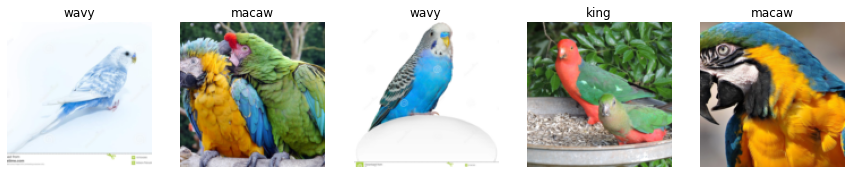

In [14]:
dls.valid.show_batch(max_n=5, nrows=1)

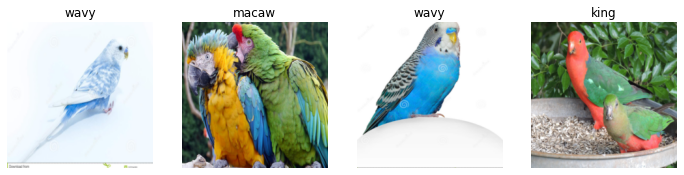

In [15]:
parrots = parrots.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # берем разные части изображения, чтобы нейронная сеть поняла, что объекты могут находиться в разных местах
    batch_tfms=aug_transforms()) #и еще растягиваем изображения под размер
dls = parrots.dataloaders(path) 
dls.valid.show_batch(max_n=4, nrows=1) #выведем 4 изображ валидационного сета в 1 строку

In [16]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.859093,2.699640,0.724138,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.760948,0.810645,0.396552,00:14
1,0.468905,0.168917,0.068965,00:13
2,0.361558,0.076677,0.034483,00:13
3,0.297558,0.048500,0.017241,00:14


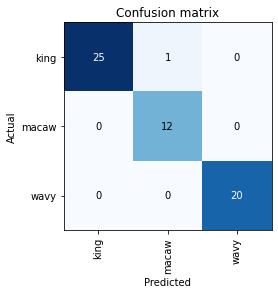

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

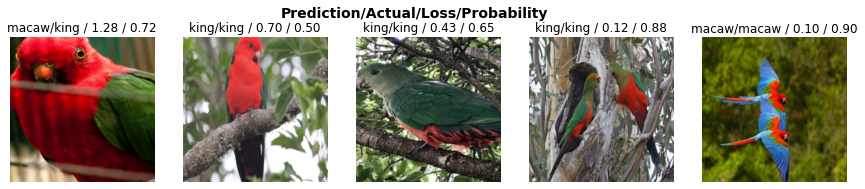

In [18]:
interp.plot_top_losses(5, nrows=1) # plot_top_losses показывает нам изображения с наибольшими потерями в нашем наборе данных; прогноз, фактический (метка), loss и probability(уровень достоверности)

In [19]:
cleaner = ImageClassifierCleaner(learn) #включаем интерфейс ImageClassifierCleaner, чтобы удалить, перемаркировать изображения
cleaner

In [20]:
import uuid
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat/f'{str(uuid.uuid4())}.{str(cleaner.fns[idx]).split(".")[-1]}')

In [21]:
learn.export(path/'export.pkl')